<a href="https://colab.research.google.com/github/JoseManuel1007/Class-Work-2025-nov-12/blob/main/Class_Work_2025_nov_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis geométrico: UdeA — Lectura y cálculo de área yperímetro
**Autor:** José Manuel Criollo Chapal  
**Descripción:** Lectura de KML, graficado en coordenadas, cálculo de perímetro y área por tres métodos (Riemann, Integral de línea y aproximación por áreas), análisis de convergencia, visualización sobre mapa base y conclusiones.  
**Fecha:** 13 de Noviembre de 2025


In [1]:
# Instalación de librerías necesarias
!pip install geopandas fiona shapely pyproj fastkml rtree contextily matplotlib pandas


In [2]:
# Lectura del KML y creación del GeoDataFrame 'gdf'
import geopandas as gpd
from google.colab import files
import fiona
import pandas as pd

uploaded = files.upload()
kml_file = list(uploaded.keys())[0]

try:
    layers = fiona.listlayers(kml_file)
except Exception:
    layers = [0]

gdfs = []
for layer in layers:
    try:
        g = gpd.read_file(kml_file, layer=layer, driver='KML')
        if len(g):
            g['__layer__'] = str(layer)
            gdfs.append(g)
    except Exception:
        pass

if not gdfs:
    raise ValueError('No se pudo leer ninguna capa del KML.')

gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), geometry='geometry')
if gdf.crs is None:
    gdf = gdf.set_crs(epsg=4326)
else:
    gdf = gdf.to_crs(epsg=4326)

print('Columnas disponibles:', list(gdf.columns))
print('Número de geometrías leídas:', len(gdf))
gdf.head()


Saving Mapa UdeA.kml to Mapa UdeA (1).kml
Columnas disponibles: ['Name', 'Description', 'geometry', '__layer__']
Número de geometrías leídas: 1


,Name,Description,geometry,__layer__
0,Perimetro UdeA,,"POLYGON Z ((-75.56998 6.26495 0, -75.56766 6.2...",Mapa UdeA


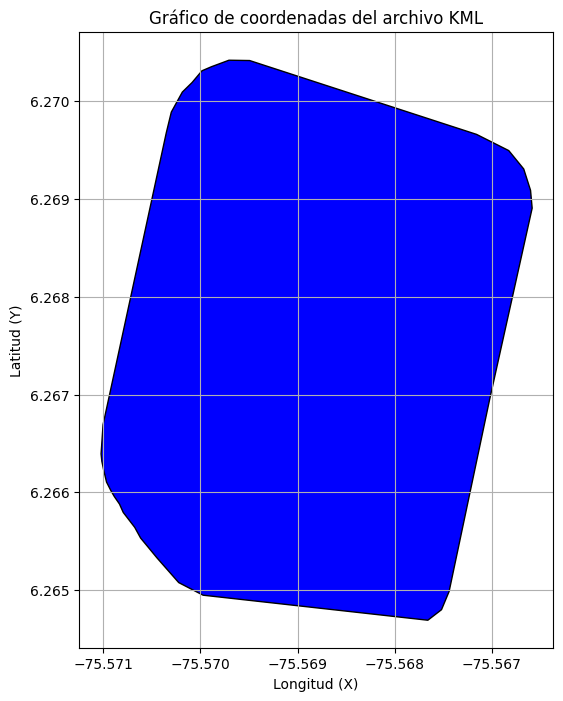

In [3]:
# Grafica las geometrías sobre ejes X (longitud) e Y (latitud)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, color='blue', edgecolor='black', linewidth=1)
ax.set_xlabel("Longitud (X)")
ax.set_ylabel("Latitud (Y)")
ax.set_title("Gráfico de coordenadas del archivo KML")
ax.grid(True)
plt.show()


In [4]:

# Selecciona el polígono de la UdeA o el polígono mayor
import numpy as np
from shapely.geometry import Polygon, MultiPolygon

cands = []
for col in ['Name','name','NAME','Nombre','nombre']:
    if col in gdf.columns:
        mask = gdf[col].astype(str).str.contains('udea|u de a|universidad de antioquia|antioquia', case=False, na=False)
        if mask.any():
            cands = gdf[mask]
            break

if getattr(cands, "empty", True):
    polys = gdf[gdf.geometry.geom_type.isin(['Polygon','MultiPolygon'])]
    if len(polys) == 0:
        raise ValueError('No hay polígonos en gdf para calcular la UdeA.')
    target = polys.geometry.area.idxmax()
    poly = polys.loc[target].geometry
else:
    polys = cands[cands.geometry.geom_type.isin(['Polygon','MultiPolygon'])]
    if len(polys) == 0:
        polys = gdf[gdf.geometry.geom_type.isin(['Polygon','MultiPolygon'])]
        target = polys.geometry.area.idxmax()
        poly = polys.loc[target].geometry
    else:
        target = polys.geometry.area.idxmax()
        poly = polys.loc[target].geometry

# Determina UTM por el centroid del polígono y proyecta el polígono a metros
centroid = poly.centroid
lon, lat = centroid.x, centroid.y
zone = int((lon + 180) / 6) + 1
epsg = 32600 + zone if centroid.y >= 0 else 32700 + zone

from pyproj import CRS
crs_utm = CRS.from_epsg(epsg)
poly_g = gpd.GeoSeries([poly], crs=gdf.crs if gdf.crs is not None else 'EPSG:4326').to_crs(crs_utm)
poly_proj = poly_g.iloc[0]

print('Centroid (lon, lat):', (lon, lat))
print('EPSG UTM seleccionado:', epsg)


Centroid (lon, lat): (-75.56885132879334, 6.267521420251357)
EPSG UTM seleccionado: 32618


/tmp/ipython-input-1701670674.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  target = polys.geometry.area.idxmax()


In [5]:
# Autor: José Manuel Criollo Chapal
# Cálculo de perímetro y área exactos usando geometría proyectada (m)
perimeter_m = poly_proj.length
area_shapely = poly_proj.area

print('Perímetro (m):', float(perimeter_m))
print('Área (Shapely, m²):', float(area_shapely))


Perímetro (m): 1843.3703352535604
Área (Shapely, m²): 235345.03429595663


In [6]:
# Cálculo de área usando 3 métodos:
# 1) Riemann vertical
# 2) Integral de línea
# 3) Triangulación

from shapely.geometry import LineString, Polygon, MultiPolygon
from shapely.ops import triangulate
import numpy as np

# Límites del polígono proyectado
minx, miny, maxx, maxy = poly_proj.bounds

# Número de muestras para el método de Riemann
n = 2000
xs = np.linspace(minx, maxx, n)
dx = xs[1] - xs[0]

# Función que calcula la longitud vertical del polígono a un valor de x
def vertical_length_at_x(x):
    # Se crea una línea vertical suficientemente larga
    line = LineString([(x, miny - (maxy - miny)), (x, maxy + (maxy - miny))])

    # Intersección de la línea con el polígono
    inter = poly_proj.intersection(line)

    # Si no hay intersección, longitud = 0
    if inter.is_empty:
        return 0.0

    total = 0.0

    # Si la intersección es multiparte, se recorren todos los segmentos
    if hasattr(inter, "geoms"):
        for g in inter.geoms:
            if hasattr(g, "length"):
                total += g.length
    else:
        # Si es una sola línea
        if hasattr(inter, "length"):
            total += inter.length

    return total

# Vector con las longitudes verticales para cada x muestreada
vec_len = np.array([vertical_length_at_x(x) for x in xs])

# Método 1: Suma de Riemann (left)
area_riemann = np.sum(vec_len[:-1]) * dx

# Método 2: Área mediante integral de línea (teorema de Green / Shoelace)
def polygon_area_by_line_integral(geom):

    # Función para calcular área de un anillo (exterior o interior)
    def ring_area(coords):
        arr = np.asarray(coords)

        # Se asegura que solo haya columnas X e Y
        if arr.shape[1] > 2:
            arr = arr[:, :2]

        x = arr[:,0]
        y = arr[:,1]

        # Se aplica la fórmula del zapatero
        x_next = np.roll(x, -1)
        y_next = np.roll(y, -1)

        return 0.5 * np.sum(x * y_next - x_next * y)

    total = 0.0

    # Caso polígono simple
    if isinstance(geom, Polygon):
        total += ring_area(geom.exterior.coords)  # Área del contorno exterior

        # Se restan huecos (anillos interiores)
        for interior in geom.interiors:
            total -= ring_area(interior.coords)

    # Caso multipolígono: se suman todos
    elif isinstance(geom, MultiPolygon):
        for poly in geom.geoms:
            total += polygon_area_by_line_integral(poly)
    else:
        raise TypeError('geom debe ser Polygon o MultiPolygon')

    return abs(total)

# Área por integral cerrada (exacta)
area_integral = polygon_area_by_line_integral(poly_proj)

# Método 3: Triangulación + intersección
tris = triangulate(poly_proj)
area_tris = 0.0

for t in tris:
    # Se intersecta cada triángulo con el polígono
    inter = t.intersection(poly_proj)

    if inter.is_empty:
        continue

    # Puede ser multiparte
    if hasattr(inter, "geoms"):
        for part in inter.geoms:
            if hasattr(part, "area"):
                area_tris += part.area
    else:
        if hasattr(inter, "area"):
            area_tris += inter.area

# Impresión de resultados
print('Área - Riemann (m²) left:', float(area_riemann))
print('Área - Integral de línea (m²):', float(area_integral))
print('Área - Triangulación (m²):', float(area_tris))



Área - Riemann (m²) left: 235344.796385354
Área - Integral de línea (m²): 235345.03424072266
Área - Triangulación (m²): 235345.03429595666


In [7]:
# Tabla comparativa de resultados y errores porcentuales
import pandas as pd

def pct_err(approx, exact):
    return 100.0 * (approx - exact) / exact

tabla = pd.DataFrame({
    'Método': ['Exacto (Shapely)', 'Riemann (left)', 'Trapecios', 'Triangulación'],
    'Área (m²)': [area_shapely, area_riemann, area_integral, area_tris],
})
tabla['Error (%)'] = [0.0,
                     pct_err(area_riemann, area_shapely),
                     pct_err(area_integral, area_shapely),
                     pct_err(area_tris, area_shapely)]
pd.options.display.float_format = '{:,.3f}'.format
tabla


,Método,Área (m²),Error (%)
0,Exacto (Shapely),"235,345.034",0.000
1,Riemann (left),"235,344.796",-0.000
2,Trapecios,"235,345.034",-0.000
3,Triangulación,"235,345.034",0.000


/tmp/ipython-input-1013896283.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  trap_test = np.trapz(vec_len_test, xs_test)


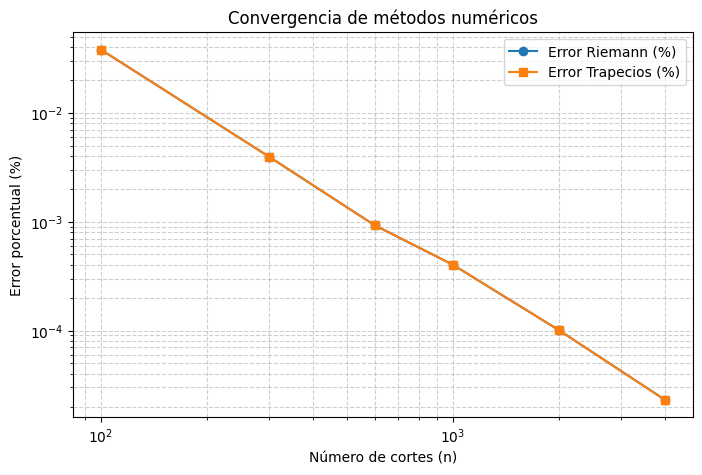

In [8]:
# Prueba de convergencia para Riemann y Trapecios con distintos n
import matplotlib.pyplot as plt

ns = [100, 300, 600, 1000, 2000, 4000]
err_r, err_t = [], []
for ntest in ns:
    xs_test = np.linspace(minx, maxx, ntest)
    dx_test = xs_test[1] - xs_test[0]
    vec_len_test = np.array([vertical_length_at_x(x) for x in xs_test])
    riem_test = np.sum(vec_len_test[:-1]) * dx_test
    trap_test = np.trapz(vec_len_test, xs_test)
    err_r.append(abs(riem_test - area_shapely) / area_shapely * 100)
    err_t.append(abs(trap_test - area_shapely) / area_shapely * 100)

plt.figure(figsize=(8,5))
plt.plot(ns, err_r, marker='o', label='Error Riemann (%)')
plt.plot(ns, err_t, marker='s', label='Error Trapecios (%)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Número de cortes (n)')
plt.ylabel('Error porcentual (%)')
plt.title('Convergencia de métodos numéricos')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.show()


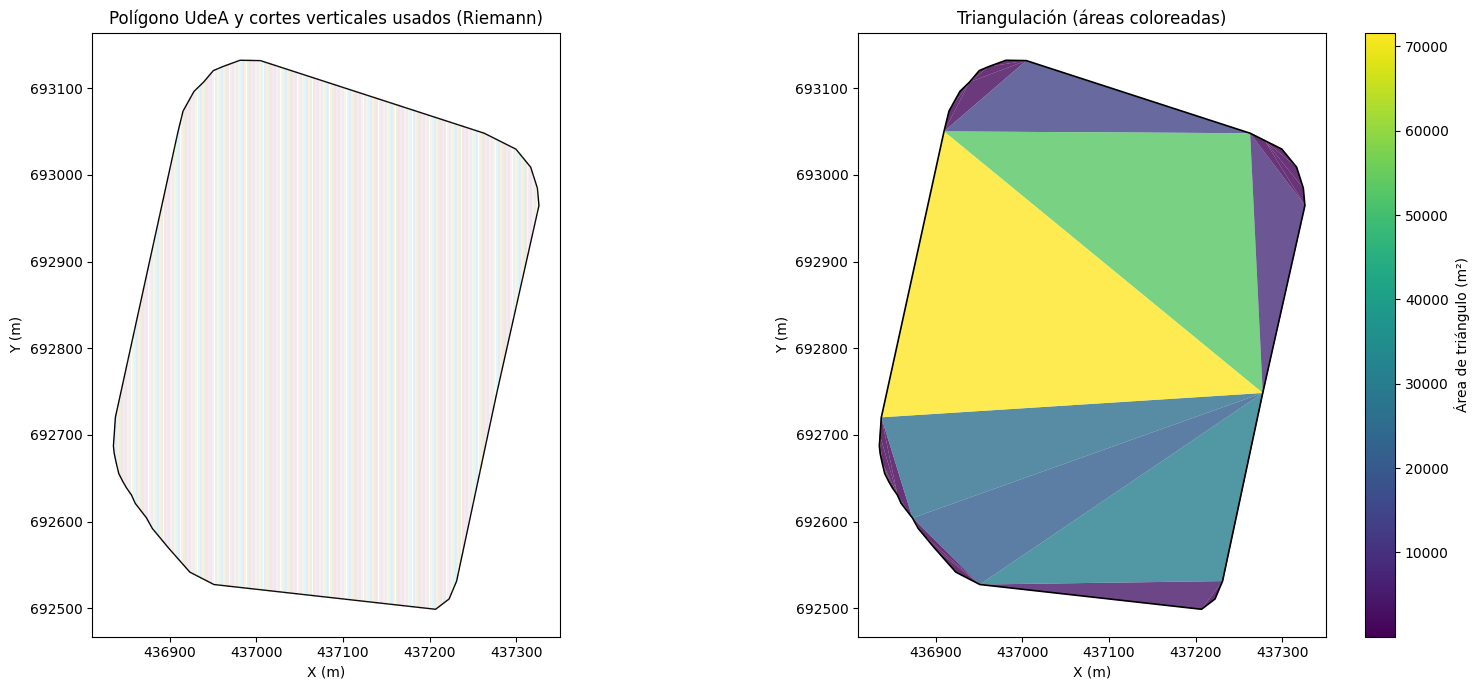

In [9]:
# Visualización detallada (triangulación coloreada y líneas de Riemann)
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from shapely.geometry import Polygon, MultiPolygon, LineString

areas_tri = [t.area for t in tris]
norm = mcolors.Normalize(vmin=min(areas_tri), vmax=max(areas_tri))
cmap = plt.cm.viridis

fig, ax = plt.subplots(1,2, figsize=(16,7))

# Polígono y líneas verticales (Riemann)
gpd.GeoSeries([poly_proj]).plot(ax=ax[0], edgecolor='black', facecolor='none')
step = max(1, int(len(xs)/200))
for x in xs[::step]:
    l = LineString([(x, miny), (x, maxy)])
    inter = poly_proj.intersection(l)
    if inter.is_empty:
        continue
    if hasattr(inter, "geoms"):
        for seg in inter.geoms:
            if getattr(seg, "geom_type", "") == 'LineString':
                ax[0].plot([seg.coords[0][0], seg.coords[-1][0]],
                           [seg.coords[0][1], seg.coords[-1][1]], alpha=0.12)
    else:
        if getattr(inter, "geom_type", "") == 'LineString':
            ax[0].plot([inter.coords[0][0], inter.coords[-1][0]],
                       [inter.coords[0][1], inter.coords[-1][1]], alpha=0.12)
ax[0].set_title('Polígono UdeA y cortes verticales usados (Riemann)')
ax[0].set_xlabel('X (m)')
ax[0].set_ylabel('Y (m)')

# Triangulación coloreada por área
for t in tris:
    inter = t.intersection(poly_proj)
    if inter.is_empty:
        continue
    parts = [inter] if not hasattr(inter, "geoms") else list(inter.geoms)
    for part in parts:
        # Si la parte tiene exterior
        if hasattr(part, "exterior") and part.exterior is not None:
            coords = list(part.exterior.coords)
            xs_t = [c[0] for c in coords]
            ys_t = [c[1] for c in coords]
            ax[1].fill(xs_t, ys_t, color=cmap(norm(part.area)), alpha=0.8, edgecolor='none')
        # Si la parte es línea, dibujar como polígono hueco
        elif getattr(part, "geom_type", "") == 'LineString':
            coords = list(part.coords)
            xs_t = [c[0] for c in coords]
            ys_t = [c[1] for c in coords]
            ax[1].plot(xs_t, ys_t, linewidth=0.8)
        # Si es un collection con subpartes, iterarlas
        elif hasattr(part, "geoms"):
            for sub in part.geoms:
                if hasattr(sub, "exterior") and sub.exterior is not None:
                    coords = list(sub.exterior.coords)
                    xs_t = [c[0] for c in coords]
                    ys_t = [c[1] for c in coords]
                    ax[1].fill(xs_t, ys_t, color=cmap(norm(sub.area)), alpha=0.8, edgecolor='none')
                elif getattr(sub, "geom_type", "") == 'LineString':
                    coords = list(sub.coords)
                    xs_t = [c[0] for c in coords]
                    ys_t = [c[1] for c in coords]
                    ax[1].plot(xs_t, ys_t, linewidth=0.8)

gpd.GeoSeries([poly_proj]).boundary.plot(ax=ax[1], color='black', linewidth=1.2)
sm = ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(sm, ax=ax[1], label='Área de triángulo (m²)')
ax[1].set_title('Triangulación (áreas coloreadas)')
ax[1].set_xlabel('X (m)')
ax[1].set_ylabel('Y (m)')

plt.tight_layout()
plt.show()



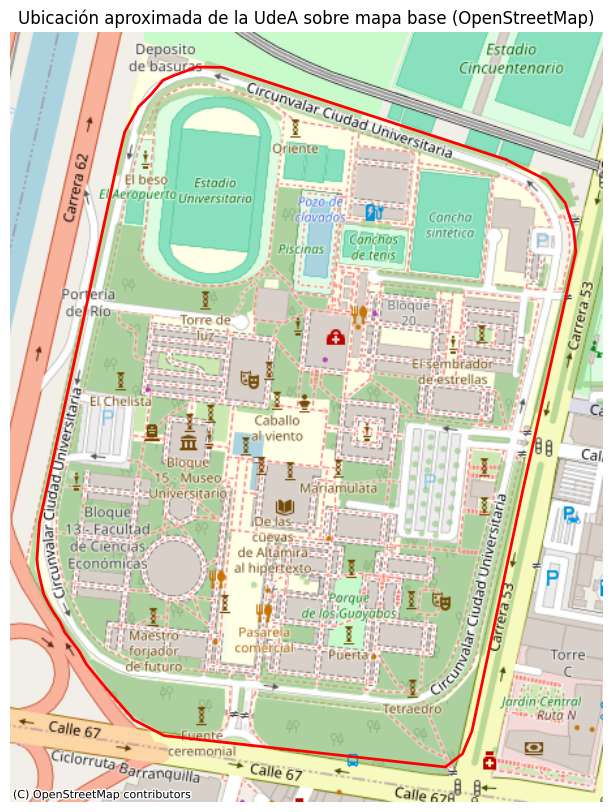

In [10]:
# Muestra el polígono sobre un mapa base
import contextily as ctx
fig, ax = plt.subplots(figsize=(10,10))
poly_web = gpd.GeoSeries([poly], crs='EPSG:4326').to_crs(epsg=3857)
poly_web.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('Ubicación aproximada de la UdeA sobre mapa base (OpenStreetMap)')
plt.show()


## Conclusiones (resumen técnico)

1. Se calculó el perímetro y el área de la Universidad de Antioquia (UdeA) usando una proyección UTM para que las unidades estén en metros. El perímetro y el área "exacta" se obtuvieron con las funciones de Shapely aplicadas a la geometría proyectada.

2. Se usaron tres métodos para aproximar el área:
   - **Sumas de Riemann (cortes verticales, left Riemann):** depende del número de cortes (`n`). Es fácil de implementar y sirve para entender la integración.
   - **Integración numérica (integral de línea):** calcula el área sumando las longitudes verticales de la geometría. Es más precisa que Riemann para formas suaves.
   - **Aproximación por figuras (triangulación):** divide el polígono en triángulos. Funciona bien para formas complejas y depende de cómo se generen los triángulos.

3. Al aumentar el número de cortes `n`, los errores de Riemann y de la integral de línea disminuyen. Se recomienda comparar los resultados numéricos con el área calculada con Shapely.

4. Graficar el polígono sobre un mapa (OpenStreetMap) ayuda a ver su ubicación real y facilita mostrar el trabajo. La triangulación y las líneas verticales usadas en la integral muestran qué zonas pueden tener más error.

5. Recomendaciones:
   - Usar siempre una proyección en metros (UTM u otra local) antes de calcular áreas y perímetros.
   - Comparar los resultados numéricos con el valor de Shapely para verificar errores.
   - Para mayor precisión, aumentar el número de cortes y refinar la triangulación en zonas complejas.




In [11]:
# Instalación de librerías
!pip install geopandas fiona shapely pyproj folium requests branca
!pip install osmnx folium shapely geopandas

In [12]:
# Lectura del KML y creación de 'gdf'
import geopandas as gpd
from google.colab import files
import fiona
import pandas as pd

uploaded = files.upload()
kml_file = list(uploaded.keys())[0]

try:
    layers = fiona.listlayers(kml_file)
except Exception:
    layers = [0]

gdfs = []
for layer in layers:
    try:
        g = gpd.read_file(kml_file, layer=layer, driver='KML')
        if len(g):
            g['__layer__'] = str(layer)
            gdfs.append(g)
    except Exception:
        pass

if not gdfs:
    raise ValueError('No se pudo leer ninguna capa del KML.')

gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), geometry='geometry')
if gdf.crs is None:
    gdf = gdf.set_crs(epsg=4326)
else:
    gdf = gdf.to_crs(epsg=4326)

print('Columnas:', list(gdf.columns))
print('Geometrías leídas:', len(gdf))
gdf.head()


Saving Ruta casa UdeA.kml to Ruta casa UdeA (7).kml
Columnas: ['Name', 'Description', 'geometry', '__layer__']
Geometrías leídas: 1


,Name,Description,geometry,__layer__
0,Camino desde casa hasta universidad,,"LINESTRING Z (-75.57126 6.26084 0, -75.57122 6...",Ruta casa UdeA


In [13]:
# Librerías
import geopandas as gpd
import osmnx as ox
import folium
from shapely.geometry import Point, LineString
from google.colab import files

# Coordenadas de casa y UdeA
home = Point(-75.57109100432139, 6.260961963677129)
udea = Point(-75.56937502021304, 6.265366175333918)

# GeoDataFrame
gdf = gpd.GeoDataFrame({'name':['home','udea'], 'geometry':[home, udea]}, crs='EPSG:4326')

# Grafo OSM
G = ox.graph_from_point((6.260, -75.568), dist=3000, network_type='walk')

# Nodos cercanos
n_home = ox.nearest_nodes(G, home.x, home.y)
n_udea = ox.nearest_nodes(G, udea.x, udea.y)

# Ruta
route = ox.shortest_path(G, n_home, n_udea)

# Línea de ruta
coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in route]
line = LineString([(c[1], c[0]) for c in coords])

# Exporta KML
route_gdf = gpd.GeoDataFrame({'name':['route'], 'geometry':[line]}, crs='EPSG:4326')
route_gdf.to_file('ruta.kml', driver='KML')
files.download('ruta.kml')

# Mapa
m = folium.Map(location=[6.260, -75.568], zoom_start=14)

# Ruta en mapa
folium.GeoJson(route_gdf).add_to(m)

# Marcadores
folium.Marker([home.y, home.x], tooltip='Casa').add_to(m)
folium.Marker([udea.y, udea.x], tooltip='UdeA').add_to(m)

# Mapa final
m


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Comparación de ruta planeada (KML) vs ruta OSM con distancias reales

!pip install geopandas folium shapely osmnx pyproj

import geopandas as gpd
import osmnx as ox
import folium
from shapely.geometry import LineString, Point
from pyproj import CRS

# -----------------------------
# 1. Coordenadas como Point
home = Point(-75.57109100432139, 6.260961963677129)
udea = Point(-75.56937502021304, 6.265366175333918)

# -----------------------------
# 2. Subir KML
from google.colab import files
uploaded = files.upload()
kml_file = list(uploaded.keys())[0]

gdf_route = gpd.read_file(kml_file, driver='KML')

# Convertir geometría a 2D
def to_2d(geom):
    if geom.geom_type == 'LineString':
        return LineString([(x, y) for x, y, *rest in geom.coords])
    return geom

gdf_route['geometry'] = gdf_route['geometry'].apply(to_2d)
gdf_route = gdf_route.set_crs(epsg=4326)

# Para calcular distancia en metros, proyectar a UTM
mid_lon = (home.x + udea.x)/2
utm_zone = int((mid_lon + 180) / 6) + 1
epsg_utm = 32600 + utm_zone  # hemisferio norte
gdf_route_utm = gdf_route.to_crs(epsg=epsg_utm)

# -----------------------------
# 3. Calcular ruta real OSM
radius = 8000  # metros
G = ox.graph_from_point((home.y, home.x), dist=radius, network_type='walk')

n_home = ox.nearest_nodes(G, home.x, home.y)
n_udea = ox.nearest_nodes(G, udea.x, udea.y)

route_nodes = ox.shortest_path(G, n_home, n_udea, weight='length')
coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in route_nodes]
route_line = LineString(coords)

gdf_real = gpd.GeoDataFrame({'name':['ruta_real'], 'geometry':[route_line]}, crs='EPSG:4326')

# Proyectar a UTM para medir distancia real en metros
gdf_real_utm = gdf_real.to_crs(epsg=epsg_utm)

# -----------------------------
# 4. Calcular distancias
kml_total = gdf_route_utm.length.sum()
real_total = gdf_real_utm.length.sum()

print(f"Distancia ruta planeada (KML) [m]: {kml_total:.1f}")
print(f"Distancia ruta OSM (real) [m]: {real_total:.1f}")

if kml_total < real_total:
    print("La ruta planeada (KML) es más corta.")
else:
    print("La ruta OSM (real) es más corta.")

# -----------------------------
# 5. Graficar rutas sobre mapa OSM
m = folium.Map(location=[(home.y + udea.y)/2, (home.x + udea.x)/2], zoom_start=15)

# Función para dibujar rutas
def add_route(gdf, color, map_obj):
    for geom in gdf.geometry:
        if geom.geom_type == 'LineString':
            folium.PolyLine([(y, x) for x, y in geom.coords], color=color, weight=4).add_to(map_obj)
        elif geom.geom_type == 'MultiLineString':
            for part in geom.geoms:
                folium.PolyLine([(y, x) for x, y in part.coords], color=color, weight=4).add_to(map_obj)

add_route(gdf_route, 'blue', m)  # Ruta KML
add_route(gdf_real, 'green', m)  # Ruta OSM

# Marcadores
folium.Marker([home.y, home.x], tooltip='Mi casa', icon=folium.Icon(color='blue')).add_to(m)
folium.Marker([udea.y, udea.x], tooltip='UdeA', icon=folium.Icon(color='red')).add_to(m)

# Mostrar mapa
m


Saving Ruta casa UdeA.kml to Ruta casa UdeA (8).kml
Distancia ruta planeada (KML) [m]: 612.2
Distancia ruta OSM (real) [m]: 630.5
La ruta planeada (KML) es más corta.
